# Barcelona climate analysis

##### Imports

In [400]:
#dataset
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#selenium
import selenium
from selenium.webdriver import Firefox
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
import time

#search downloaded file
import glob
import os

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.preprocessing import StandardScaler
from numpy import asarray

#test and train split
from sklearn.model_selection import train_test_split

#search best parameters
from sklearn.model_selection import RandomizedSearchCV

#regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

#clustering
from kneed import KneeLocator
import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 1. Web scraping

This part of the code contains web scraping process of Barcelona Open Data web page to obtain historical temperature and precipitation data. The objective is to create a new data set for future analysis and machine learning model.

In [43]:
#get page
opts = Options()
opts.headless = True
browser = Firefox(options=opts)
path1 = 'https://opendata-ajuntament.barcelona.cat/data/ca/dataset/temperatures-hist-bcn/resource/0e3b6840-7dff-4731-a556-44fac28a7873'
path2 = 'https://opendata-ajuntament.barcelona.cat/data/ca/dataset/precipitacio-hist-bcn/resource/6f1fb778-0767-478b-b332-c64a833d26d2'
#get first dataset
browser.get(path1)

In [44]:
#print title of the page
print(browser.title)

Temperatures mitjanes mensuals de l’aire de la ciutat de Barcelona des de 1780 - TemperaturesBarcelonaDesDe1780.csv - Open Data Barcelona


In [50]:
#print title of the page
file_name1 = browser.find_element(By.XPATH,'//*[@id="content"]/div[3]/section/div/h1').text
print(file_name1)

TemperaturesBarcelonaDesDe1780.csv


In [47]:
#search for download button
link1 = browser.find_element(By.CLASS_NAME, 'resource-type-None').click()

In [48]:
#search for latest downloaded file
files_path = os.path.join('/Users/dominikapetru/Downloads/*')
file1 = sorted(glob.iglob(files_path), key=os.path.getctime, reverse=True)
file_path = file1[0]
print(file_path)

/Users/dominikapetru/Downloads/S7F_dQ+j.csv.part


In [52]:
#copy dataset to github repository and change name
df_download = pd.read_csv(open(file_path))
df_download.to_csv(file_name1)

In [55]:
#get second dataset
browser.get(path2)

In [56]:
#print title of the page
file_name2 = browser.find_element(By.XPATH,'//*[@id="content"]/div[3]/section/div/h1').text
print(file_name2)

PrecipitacionsBarcelonaDesDe1786.csv


In [57]:
#search for download button
link2 = browser.find_element(By.CLASS_NAME, 'resource-type-None').click()

In [58]:
#search for latest downloaded file
files_path = os.path.join('/Users/dominikapetru/Downloads/*')
file2 = sorted(glob.iglob(files_path), key=os.path.getctime, reverse=True)
file_path = file2[0]
print(file_path)

/Users/dominikapetru/Downloads/_0ljHIbC.csv.part


In [59]:
#copy dataset to github repository and change name
df_download = pd.read_csv(open(file_path))
df_download.to_csv(file_name2)

In [60]:
browser.close()

### 2. Dataset

This part of the code contains changes in both data sets in order to get one clean database of temperature and precipitation values. This part is very important for future analysis because it would be possible to study the relationship between average temperature and accumulated precipitation.

In [270]:
#get dataset from GitHub repository
df_temp = pd.read_csv('TemperaturesBarcelonaDesDe1780.csv')
df2 = pd.read_csv('PrecipitacionsBarcelonaDesDe1786.csv')

In [271]:
#keep values only from years 1786 and higher
mask = df_temp['Any'] >= 1786
df1 = df_temp[mask]

In [272]:
#delete column Unnamed
df1.drop('Unnamed: 0', axis=1, inplace=True)
df2.drop('Unnamed: 0', axis=1, inplace=True)

In [273]:
#rename columns to english
df1.rename(columns={"Any": "Year",
                   'Temp_Mitjana_Gener': 1,
                   'Temp_Mitjana_Febrer': 2,
                   'Temp_Mitjana_Marc': 3,
                   'Temp_Mitjana_Abril': 4,
                   'Temp_Mitjana_Maig': 5,
                   'Temp_Mitjana_Juny': 6,
                   'Temp_Mitjana_Juliol': 7,
                   'Temp_Mitjana_Agost': 8,
                   'Temp_Mitjana_Setembre': 9,
                   'Temp_Mitjana_Octubre': 10,
                   'Temp_Mitjana_Novembre': 11,
                   'Temp_Mitjana_Desembre': 12},inplace=True)
df1.head()

,Year,1,2,3,4,5,6,7,8,9,10,11,12
6,1786,7.8,8.3,9.9,12.8,16.8,20.2,20.9,21.1,19.5,15.5,9.2,8.3
7,1787,5.4,7.8,11.3,12.1,14.7,19.2,21.0,21.8,19.4,15.5,9.3,10.8
8,1788,6.4,10.1,10.4,12.5,17.1,19.2,22.1,23.0,19.1,15.5,10.5,5.4
9,1789,6.9,9.3,8.7,13.3,17.7,18.5,20.9,21.9,20.0,14.7,7.8,7.3
10,1790,7.4,9.5,10.4,12.3,15.0,19.0,20.8,23.1,19.3,17.1,11.7,7.9


In [274]:
#rename columns to english
df2.rename(columns={"Any": "Year",
                   'Precip_Acum_Gener': 1,
                   'Precip_Acum_Febrer': 2,
                   'Precip_Acum_Marc': 3,
                   'Precip_Acum_Abril': 4,
                   'Precip_Acum_Maig': 5,
                   'Precip_Acum_Juny': 6,
                   'Precip_Acum_Juliol': 7,
                   'Precip_Acum_Agost': 8,
                   'Precip_Acum_Setembre': 9,
                   'Precip_Acum_Octubre': 10,
                   'Precip_Acum_Novembre': 11,
                   'Precip_Acum_Desembre': 12},inplace=True)
df2.head()

,Year,1,2,3,4,5,6,7,8,9,10,11,12
0,1786,32.8,28.4,84.4,42.3,8.5,38.0,6.8,52.1,62.0,57.0,195.8,114.1
1,1787,136.4,27.4,44.6,76.9,0.0,29.8,34.7,14.9,205.8,12.4,42.2,0.0
2,1788,9.9,14.9,32.2,12.4,7.5,146.3,59.4,29.8,123.9,163.6,106.6,22.3
3,1789,12.4,12.4,23.6,9.9,32.2,9.9,6.3,69.4,18.7,52.1,18.7,76.9
4,1790,44.6,1.2,188.5,74.4,44.7,39.7,65.7,32.3,71.9,205.8,72.0,14.9


In [277]:
#reorganize dataset temp
df_temp = df1.melt(id_vars=["Year"],var_name="Month")
df_temp.rename(columns={"value": "Temp"},inplace=True)
df_temp.sort_values(by=["Year", "Month"],inplace=True)

#reorganize dataset precip
df_precip = df2.melt(id_vars=["Year"],var_name="Month")
df_precip.rename(columns={"value": "Precip"},inplace=True)
df_precip.sort_values(by=["Year", "Month"],inplace=True)

#join in one dataset
df_final = pd.concat([df_temp, df_precip['Precip']], axis=1)

#reseting index
df_final.reset_index(inplace=True)
df_final.drop('index', axis=1, inplace=True)

In [278]:
df_final.head(5)

,Year,Month,Temp,Precip
0,1786,1,7.8,32.8
1,1786,2,8.3,28.4
2,1786,3,9.9,84.4
3,1786,4,12.8,42.3
4,1786,5,16.8,8.5


In [279]:
#info about dataset
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    2820 non-null   int64  
 1   Month   2820 non-null   object 
 2   Temp    2820 non-null   float64
 3   Precip  2820 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 88.2+ KB


In [282]:
#change month to int
df_final['Month'] = df_final['Month'].astype(int)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    2820 non-null   int64  
 1   Month   2820 non-null   int64  
 2   Temp    2820 non-null   float64
 3   Precip  2820 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 88.2 KB


In [283]:
#are there any nan values?
df_final.isnull().sum()

Year      0
Month     0
Temp      0
Precip    0
dtype: int64

In [284]:
#basic statistics
df_final.describe()

,Year,Month,Temp,Precip
count,2820.000000,2820.000000,2820.000000,2820.000000
mean,1903.000000,6.500000,14.570674,49.414504
std,67.850074,3.452665,5.519488,45.308732
min,1786.000000,1.000000,2.500000,0.000000
25%,1844.000000,3.750000,9.700000,16.775000
50%,1903.000000,6.500000,14.000000,37.550000
75%,1962.000000,9.250000,19.600000,69.100000
max,2020.000000,12.000000,28.500000,365.800000


### 3. Data processing and exploratory analysis

Dataset has 2820 entries and 4 features. Features represent year, month, average temperature and accumulated prtecipitation.

In [285]:
#monthly distribution of temperature
df_final['Temp'].describe()

count    2820.000000
mean       14.570674
std         5.519488
min         2.500000
25%         9.700000
50%        14.000000
75%        19.600000
max        28.500000
Name: Temp, dtype: float64

Distribution of temperature values is balanced during the year.

In [286]:
#monthly distribution of precipitation
df_final['Precip'].describe()

count    2820.000000
mean       49.414504
std        45.308732
min         0.000000
25%        16.775000
50%        37.550000
75%        69.100000
max       365.800000
Name: Precip, dtype: float64

There are very high values in fourth quartile, during rainy months rains a lot. Rainy months have very high accumulated precipitations in comparison to the rest of the year.

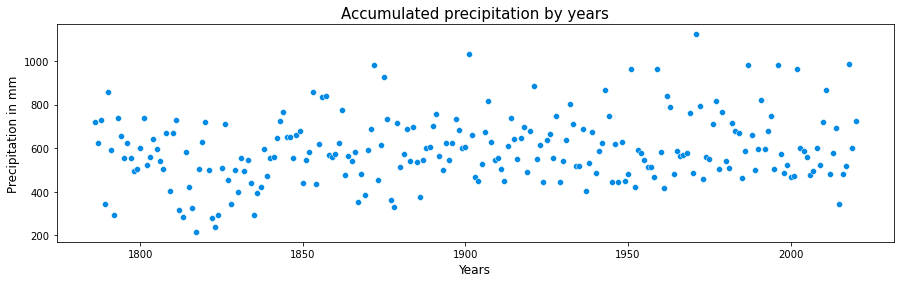

In [287]:
#total rain during the observed years
df_precip_by_year = df_final[['Year','Precip']]
rain = df_precip_by_year.groupby('Year').sum()

#scatterplot
plt.figure(figsize =(15, 4))
sns.scatterplot(x=rain.index,y=rain['Precip'],color='#008ae6')
plt.title("Accumulated precipitation by years",fontsize=15)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.show()

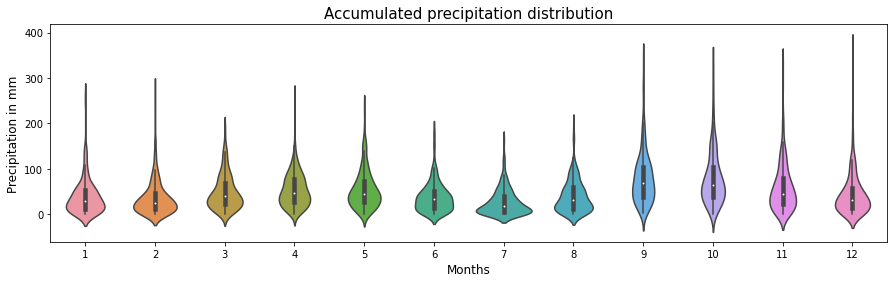

In [288]:
#distribution of precipitation
plt.figure(figsize =(15, 4))
sns.violinplot(x="Month", y="Precip", data=df_final)
plt.title("Accumulated precipitation distribution",fontsize=15)
plt.xlabel("Months",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.show()

Median in each month is represented by white dot, back bar in the center represents interquartile range and the black lines stretched from the bar are lower and upper adjacent values. These values can be used for outlier detection. The violin plot also shows the distribution of data.

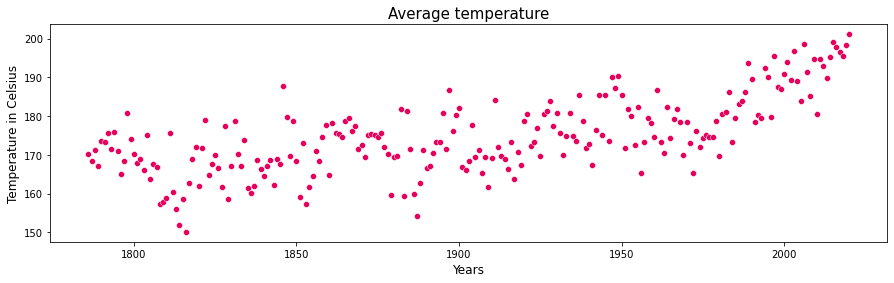

In [289]:
#total temperature during the observed years
df_temp_by_year = df_final[['Year','Temp']]
temp = df_temp_by_year.groupby('Year').sum()

#scatterplot
plt.figure(figsize =(15, 4))
sns.scatterplot(x=temp.index,y=temp['Temp'],color='#e6005c')
plt.title("Average temperature",fontsize=15)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Temperature in Celsius",fontsize=12)
plt.show()

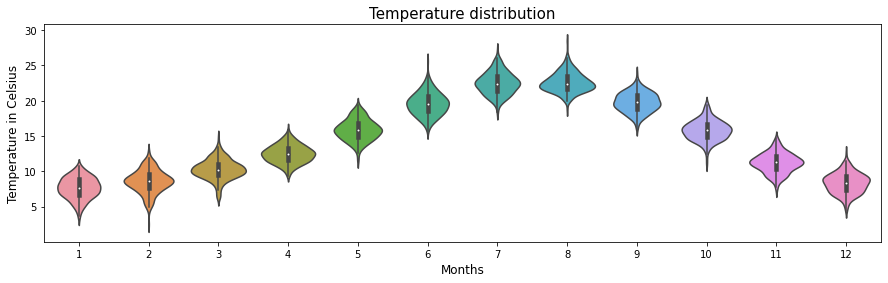

In [290]:
#distribution of precipitation
plt.figure(figsize =(15, 4))
sns.violinplot(x="Month", y="Temp", data=df_final)
plt.title("Temperature distribution",fontsize=15)
plt.xlabel("Months",fontsize=12)
plt.ylabel("Temperature in Celsius",fontsize=12)
plt.show()

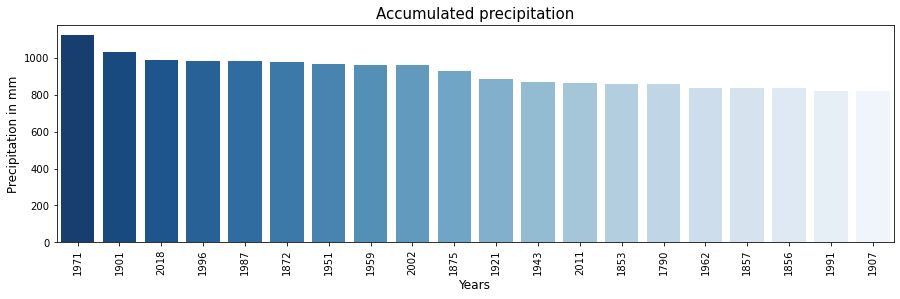

In [291]:
#years with the most accumulated precipitation
rain.sort_values(by='Precip',ascending=False, inplace=True)
high_rain = rain.head(20)
high_rain.reset_index(inplace=True)

plt.figure(figsize =(15, 4))
sns.barplot(x="Year", y="Precip", data=high_rain,order=high_rain['Year'], palette="Blues_r")
plt.title("Accumulated precipitation",fontsize=15)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.xticks(rotation=90)
plt.show()

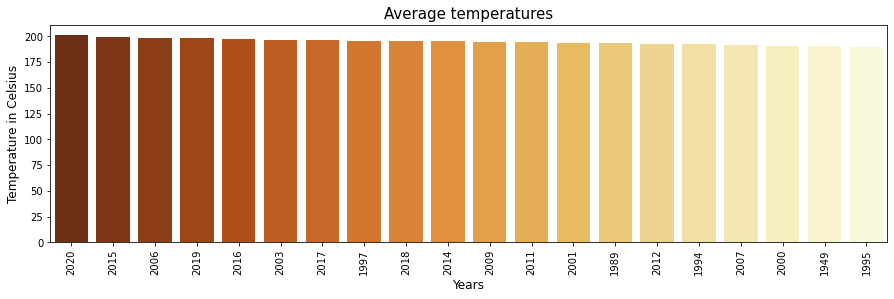

In [292]:
#years with the highest temperatures
temp.sort_values(by='Temp',ascending=False, inplace=True)
high_temp = temp.head(20)
high_temp.reset_index(inplace=True)

plt.figure(figsize =(15, 4))
sns.barplot(x="Year", y="Temp", data=high_temp,order=high_temp['Year'], palette="YlOrBr_r")
plt.title("Average temperatures",fontsize=15)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Temperature in Celsius",fontsize=12)
plt.xticks(rotation=90)
plt.show()

Conclusion:
- Average temperatures are higher in more recent years.
- Precipitation levels in recent years are not so high as in period 1970 - 1980.
- During December we can observe the most variation in precipitation values.

### 4. Machine learning

#### Supervised - Regression

Machine learning model to target feature 'Temp'. Use of feature engineering methods and 3 different models to choose the best according the results.

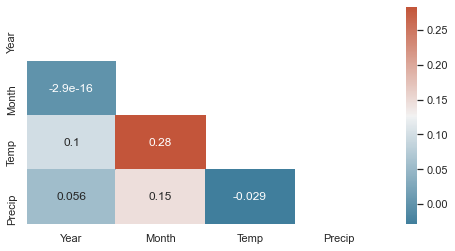

In [466]:
#correlation matrix
fig,ax = plt.subplots(figsize=(8, 4))
corr = df_final.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)
plt.show()

Temperature is correlated with month values but not with precipitation or Year. More data would be necessary so that other features could be studied.

In [406]:
#stratified dataset sample to obtain 50 values of each month
df_sample = df_final.groupby('Month', group_keys=False).apply(lambda x: x.sample(50))
df_sample['Month'].value_counts()

1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
11    50
12    50
Name: Month, dtype: int64

In [407]:
#split dataset
X = df_sample.drop(['Temp'],axis=1)
y = df_sample['Temp']

In [408]:
#standardize data
scaler = StandardScaler()
data = asarray(X)
df_scaled = pd.DataFrame(scaler.fit_transform(data),columns=X.columns)

In [409]:
#train and test
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.30, random_state=42)

In [410]:
print(X_train.shape,X_test.shape)

(420, 3) (180, 3)


In [411]:
#GridSearch process
rf = RandomForestRegressor()
parameters1 = {'n_estimators':[50, 100, 150, 200],
              'criterion':['squared_error', 'absolute_error', 'poisson']}
model1 = RandomizedSearchCV(rf, parameters1, cv=10, random_state=11)

svr = SVR()
parameters2 = {'kernel': ['linear','rbf','sigmoid'],
              'coef0': [0.00, 0.05, 1.0, 2.0,],
              'C': [0.05, 0.5, 1.0, 1.5, 2.0, 2.5]}
model2 = RandomizedSearchCV(svr, parameters2, cv=10, random_state=11)

#Fit model
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

#Prediction
y_pred_rf = search1.predict(X_test)
y_pred_svr = search2.predict(X_test)

#Score
print('Random Forest Regression: ', model1.score(X_test, y_test))
print('Support Vector Regression: ', model2.score(X_test, y_test))

Random Forest Regression:  0.2511608942185356
Support Vector Regression:  0.8967369382848421


SVR seems to get better results in prediction of temperature in Barcelona climate data set.

In [412]:
#error
error1 = abs(y_pred_rf - y_test)
error2 = abs(y_pred_svr - y_test)

print('Mean Absolute Error Random Forest model:', round(np.mean(error1), 2), 'Celsius.')
print('Mean Absolute Error SVR model:', round(np.mean(error2), 2), 'Celsius.')

Mean Absolute Error Random Forest model: 3.43 Celsius.
Mean Absolute Error SVR model: 1.36 Celsius.


In [413]:
#scores
R_SQ1 = model1.score(X_test, y_pred_rf)
MSE1 = mean_squared_error(y_test, y_pred_rf)
RMSE1 = np.sqrt(MSE1)

R_SQ2 = model2.score(X_test, y_pred_svr)
MSE2 = mean_squared_error(y_test, y_pred_svr)
RMSE2 = np.sqrt(MSE2)

print('R2 score Random Forest model:', round(np.mean(R_SQ1), 2))
print('Mean Squared Error Random Forest model:', round(np.mean(MSE1), 2))
print('Root Mean Squared Error Random Forest model:', round(np.mean(RMSE1), 2))
print()
print('R2 score SVR model:', round(np.mean(R_SQ2), 2))
print('Mean Squared Error SVR model:', round(np.mean(MSE2), 2))
print('Root Mean Squared Error SVR model:', round(np.mean(RMSE2), 2))

R2 score Random Forest model: 0.42
Mean Squared Error Random Forest model: 20.02
Root Mean Squared Error Random Forest model: 4.47

R2 score SVR model: 0.98
Mean Squared Error SVR model: 3.16
Root Mean Squared Error SVR model: 1.78


Conclusion: 
- SVR model is performing better than Random Forest model.
- Mean Squared error is much more higher in Random Forest model than SVR model.

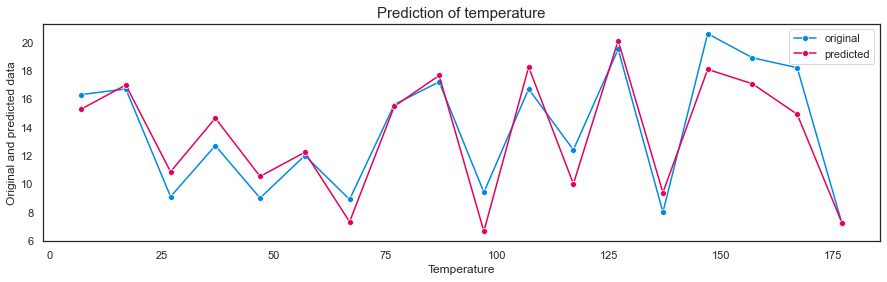

In [414]:
#compare values from test and predict
y1 = y_test.reset_index(drop=True)
y2 = pd.Series(model2.predict(X_test))

#for simple visualization let's take sistematic sample
step_num = 10
def randomNum():
    num = np.random.randint(1, 50)
    return num
num = randomNum()

simple_df1 = y1[num:len(y1):step_num]
simple_df2 = y2[num:len(y2):step_num]

plt.figure(figsize =(15, 4))
sns.lineplot(data=simple_df1, color='#008ae6',label='original', marker='o')
sns.lineplot(data=simple_df2, color='#e6005c',label='predicted', marker='o')
plt.title("Prediction of temperature",fontsize=15)
plt.xlabel("Temperature",fontsize=12)
plt.ylabel("Original and predicted data",fontsize=12)

plt.show()

#### Unsupervised - Clustering

Machine learning model to segment data in clusters.

In [433]:
df_sample.head()

,Year,Month,Temp,Precip
2028,1955,1,10.6,94.9
576,1834,1,10.1,2.4
2532,1997,1,8.7,152.1
1644,1923,1,5.9,20.9
468,1825,1,6.1,0.0


In [434]:
#pca to reduce to 2 dimensions
pca = PCA(n_components=2)
components = pca.fit_transform(df_sample)
df_principal = pd.DataFrame(data = components, columns = ['principal component 1', 'principal component 2'])

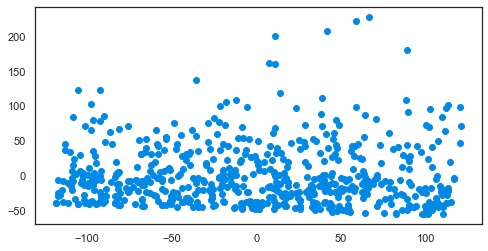

In [467]:
#data visualization
plt.figure(figsize=(8, 4))
plt.scatter(x=df_principal.iloc[:, 0], y=df_principal.iloc[:, 1],color='#008ae6')
plt.show()

In [458]:
#how many clusters? elbow method
sse = []
for k in range(2, 10):
    model = KMeans(n_clusters=k, max_iter= 300, random_state= 42)
    model.fit(df_principal)
    sse.append(model.inertia_)
kl = KneeLocator(range(2, 10), sse, curve="convex", direction="decreasing")
print('Ideal cluster number is:', kl.elbow)

Ideal cluster number is: 5


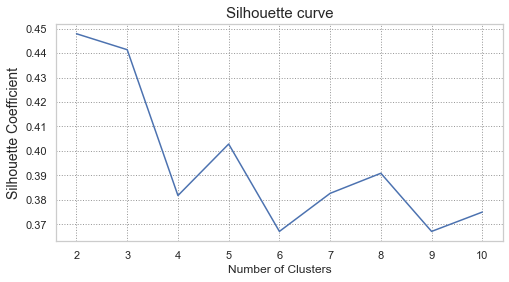

In [468]:
#silhouette curve
silhouette_coefficients = []
for k in range(2, 11):
    model = KMeans(n_clusters=k, **kmeans_kwargs)
    model.fit(df_principal)
    score1 = silhouette_score(df_principal, model.labels_)
    silhouette_coefficients.append(score1)

plt.figure(figsize=(8, 4)) 
sns.set_style('whitegrid', {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.title("Silhouette curve", fontsize = 15)
plt.xlabel("Number of Clusters",fontsize = 12)
plt.ylabel("Silhouette Coefficient",fontsize = 14)
plt.show()

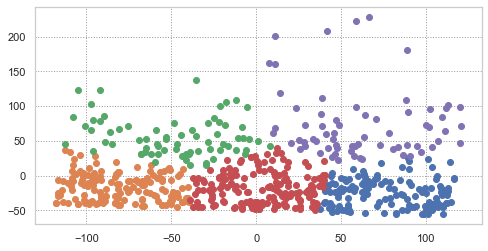

In [469]:
#kmeans algorithm
kmeans = KMeans(init="random", n_clusters=5, random_state=55)
labels = kmeans.fit_predict(df_sample)

#data visualization
plt.figure(figsize=(8, 4))
for i in np.unique(labels):
    filtered_label = df_principal[labels == i]
    plt.scatter(filtered_label.iloc[:, 0] , filtered_label.iloc[:, 1])

plt.show()

In [464]:
#score
kmeans_silhouette = silhouette_score(df_principal, kmeans.labels_).round(2)
print('Silhouette score is:',kmeans_silhouette)

Silhouette score is: 0.4


In [462]:
#data distribution
df_sample["clusters"] = labels
for i in range(5):
    df_cluster = df_sample[df_sample["clusters"] == i]
    print(df_cluster.describe())

              Year       Month        Temp      Precip  clusters
count   152.000000  152.000000  152.000000  152.000000     152.0
mean   1823.361842    6.223684   13.441447   26.117763       0.0
std      22.774608    3.597640    5.509179   18.843651       0.0
min    1786.000000    1.000000    5.200000    0.000000       0.0
25%    1804.000000    3.000000    8.700000    9.850000       0.0
50%    1822.000000    6.000000   11.650000   25.350000       0.0
75%    1841.750000    9.000000   18.300000   39.700000       0.0
max    1865.000000   12.000000   23.800000   76.900000       0.0
              Year      Month       Temp      Precip  clusters
count    71.000000  71.000000  71.000000   71.000000      71.0
mean   1849.746479   7.225352  14.049296  100.315493       1.0
std      31.584227   3.300204   4.718380   26.811446       0.0
min    1786.000000   1.000000   6.200000   60.500000       1.0
25%    1832.000000   4.000000  10.100000   81.250000       1.0
50%    1856.000000   9.000000  14.400

Conclusions:
- Cluster 4 is the cluster of outliers. High differences between values during the autumn months.
- Temperature is not correlated with precipitation.